# Direct Regression

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadstat
import re
import string
import sklearn
from sklearn_pandas import DataFrameMapper
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from tqdm import tqdm_notebook as tqdm
#from cinspect import dependence, importance
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import r2_score
import pickle
import time

from reed import drop_missing_treatment_or_outcome, Model

# set global notebook options
pd.options.display.max_columns = 200
pd.options.display.max_rows = 500
pd.options.display.max_colwidth = 100

%matplotlib inline

%load_ext autoreload
%autoreload 2

## Response Model

How well can we predict outcomes $Y$ conditional on treatment $T$ and other covariates $Z$?

### Treatent variables

   - **reduhl**	Completed re-education based on highest level of attainment
   - **redudl**	Completed re-education based on detailed qualifications
   - **redufl**	Completed re-education using highest lvl and detailed qualifications.

### Outcome variables
   - Mental health in 2019 (**mh**). This is the transformed mental health scores from the aggregation of mental health items of the SF-36 Health Survey, as reported by the individual in 2019. It ranges from 0 to 100, with higher scores indicating better mental health.  
   - Working hours in 2019 (**wkhr**) records the total number of hours the individual works in all jobs in a week on average. Working hours are set to 0 for those not working. 
   - Hourly Wages in 2019 (**rlwage**) records the average hourly wage for the individual’s main job in 2019. Hourly wages are set to 0 for those not working and set to missing for those reporting working more than 100 hours a week. 
   
#### Columns explicitly excluded
   - **xwaveid** (unique identifier)
   - **p_rcom*** (timing of completion of re-education, proxies treatment) TODO think about how we would include this
   - **p_cotrl** (first avail 2003)
   - **p_rdf*** (first avail 2012)

#### Select modeling parameters

In [2]:
outcome = 'y'#'y_wsce'
treatment = 't'
optimisation_metric = 'neg_mean_squared_error'
evaluation_metrics = ('r2','neg_mean_squared_error')
data_file = "sythetic_data.scsv"

### Load Data 
   - drop rows missing the specified treatment or outcome

In [3]:
data = pd.read_csv(data_file,index_col=0)
data.drop(columns=["p(t=1)"],inplace=True)

### Set up models
Specify which models to use and the hyper-parameter space to search over for each

In [4]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import GradientBoostingRegressor
from direct_regression import importance_from_coef

def construct_models():
    models = [
        Model('ridge',Ridge(), 
              parameters = {
                  'alpha':np.logspace(-1,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('lasso',Lasso(),
              parameters = {
                  'alpha':np.logspace(-2,4,30)
              },
              importance_func=importance_from_coef
        ),
        Model('linear',LinearRegression())
#         Model('gbr',GradientBoostingRegressor(n_iter_no_change=20, max_depth=2),
#               parameters = {
#                 'max_features':np.linspace(0,1,6)[1:],
#                 'learning_rate':np.logspace(-3,0,10),
#                 'min_samples_leaf':np.logspace(0,3,10).astype(int)
#               }
#         ),
    ]
    return models


### Prepare data for modeling
   - split into treated/control
   - impute missing values and scale
   - separate features from outcomes&treatments

In [5]:
from direct_regression import seperate_and_transform_data
X0, X1, y0, y1, X, y, t, features = seperate_and_transform_data(data, treatment, outcome)

print("Control data dimensions: ",X0.shape)
print("Treated data dimensions:",X1.shape)


Control data dimensions:  (3608, 107)
Treated data dimensions: (1346, 107)


### Compute unconditional/unadjusted estimate of treatment effect

In [6]:
from direct_regression import print_unconditional_effects
print_unconditional_effects(data, treatment, y0, y1)

Proportion Treated:27%
Average outcome under Control:-63.68±17.51
Average outcome under Treatment:133.95±29.45
Unadjusted treatment estimate 197.63


## Modelling

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from bootstrap import bootstrap_samples, shuffled_samples, GroupAwareKFold

def extract_alpha(estimators):
    return np.array([e.best_params_['alpha'] for e in estimators])

def extract_r2(estimators, X, y):
    scores = np.zeros(len(estimators))
    for i,e in enumerate(estimators):
        y_pred = e.best_estimator_.predict(X)
        scores[i] = r2_score(y, y_pred)
    return scores

n_splits = 5
simulations = 100
models = construct_models()

X0_train, X0_test, y0_train, y0_test = train_test_split(X0,y0)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)


X_test = np.vstack((X0_test, X1_test))
X_train = np.vstack((X0_train, X1_train))

m = models[0]

In [8]:
from sklearn.model_selection import GroupKFold

def fit_repeated_models(cv, estimator, param_grid, samples, X, y):
    groups = np.arange(len(y))
    estimators = []
    
    for s in samples:
        Xs, ys, gs = X[s], y[s], groups[s]
        model = GridSearchCV(estimator, param_grid=param_grid, cv=cv)
        model.fit(Xs, ys, groups=gs)
        estimators.append(model)
    return estimators

def visualise(estimators, X_train, X_test, y_train, y_test, label):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].hist(extract_alpha(estimators))
    ax[1].hist(extract_r2(estimators,X_test,y_test),label="test")
    ax[1].hist(extract_r2(estimators,X_train,y_train),label="train")
    ax[0].set_title(f"{label}: Distribution over alpha")
    ax[1].set_title(f"{label}:R2 scores")
    ax[1].legend(loc="upper left")

In [9]:
def estimate_tau(estimators0, estimators1, X0, X1):
    """Estimation of tau using model for both sides."""
    assert len(estimators0) == len(estimators1)
    effect_on_treated = np.zeros(len(estimators0))
    effect_on_control = np.zeros(len(estimators0))
    effect = np.zeros(len(estimators0))
    for i, (e0, e1) in enumerate(zip(estimators0,estimators1)):
        tau0 = e1.best_estimator_.predict(X0) - e0.best_estimator_.predict(X0)
        tau1 = e1.best_estimator_.predict(X1) - e0.best_estimator_.predict(X1)
        effect_on_control[i] = np.mean(tau0)
        effect_on_treated[i] = np.mean(tau1)
        effect[i] = np.mean([np.mean(tau0),np.mean(tau1)])
        
    return effect_on_control, effect_on_treated, effect

def estimate_tau2(estimators0, estimators1, X0, X1, y0, y1):
    """Estimation of tau using model for missing side."""
    assert len(estimators0) == len(estimators1)
    effect_on_treated = np.zeros(len(estimators0))
    effect_on_control = np.zeros(len(estimators0))
    effect = np.zeros(len(estimators0))
    for i, (e0, e1) in enumerate(zip(estimators0,estimators1)):
        tau0 = e1.best_estimator_.predict(X0) - y0
        tau1 = y1 - e0.best_estimator_.predict(X1)
        effect_on_control[i] = np.mean(tau0)
        effect_on_treated[i] = np.mean(tau1)
        effect[i] = np.mean([np.mean(tau0),np.mean(tau1)])
    return effect_on_control, effect_on_treated, effect

    
def visualise_tau(estimators0, estimators1, X0, X1, y0, y1):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    eoc, eot, tau = estimate_tau(estimators0, estimators1, X0, X1)
    eoc2, eot2, tau2 = estimate_tau2(estimators0, estimators1, X0, X1, y0, y1)

    ax[0].set_title("Effect on Control")
    ax[0].hist(eoc, label="method1")
    ax[0].hist(eoc2, label="method2")
    ax[0].legend(loc="upper left")
    
    ax[1].set_title("Effect on Treated")
    ax[1].hist(eot, label="method1")
    ax[1].hist(eot2, label="method2")

    
    ax[2].set_title("ATE")
    ax[2].hist(tau, label="method1")
    ax[2].hist(tau2, label="method2")
    
def select_and_visualise(m, samples0, samples1, cv):

    est0 = fit_repeated_models(cv, m.estimator, m.parameters, samples0, X0_train, y0_train)
    visualise(est0, X0_train, X0_test, y0_train, y0_test, "Control")

    
    est1 = fit_repeated_models(cv, m.estimator, m.parameters, samples1, X1_train, y1_train)
    visualise(est1, X1_train, X1_test, y1_train, y1_test, "Treated")

    visualise_tau(est0, est1, X0_test, X1_test, y0_test, y1_test)
    visualise_tau(est0, est1, X0_train, X1_train, y0_train, y1_train)
    return est0, est1
    

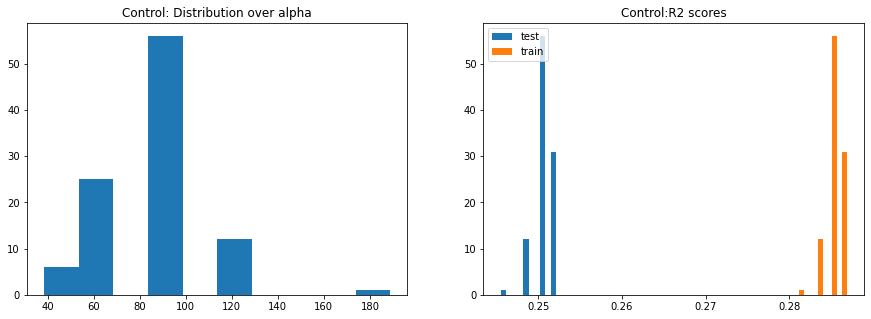

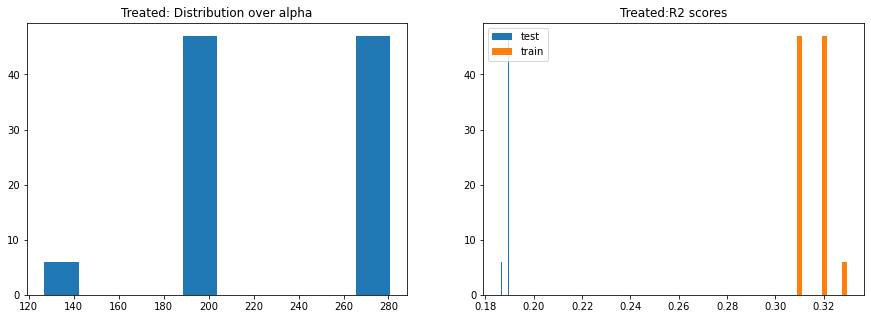

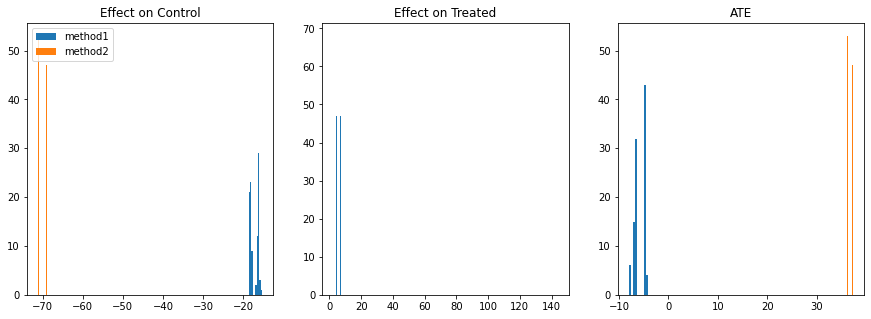

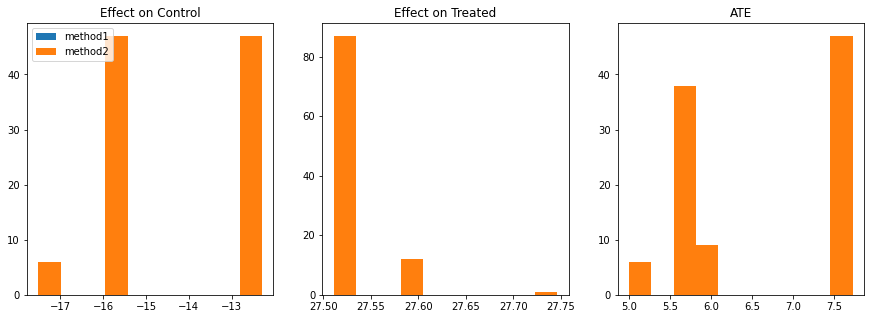

In [10]:
cv = GroupAwareKFold(n_splits=n_splits)

samples0 = shuffled_samples(len(X0_train),simulations)
samples1 = shuffled_samples(len(X1_train),simulations)

est01, est11 = select_and_visualise(m, samples0, samples1, cv)

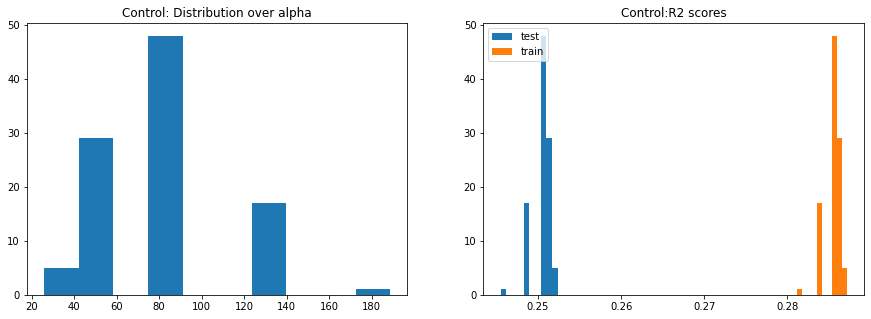

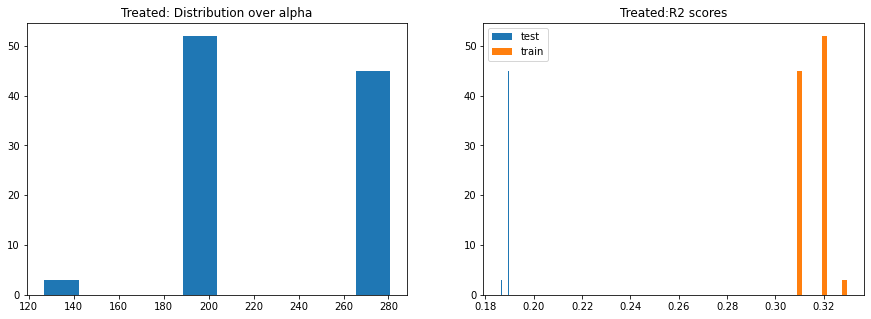

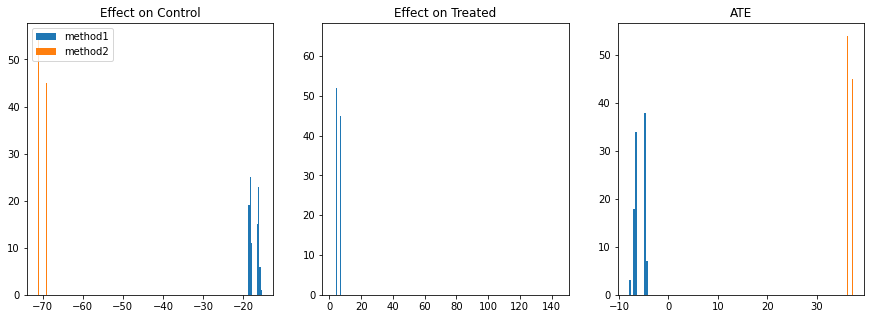

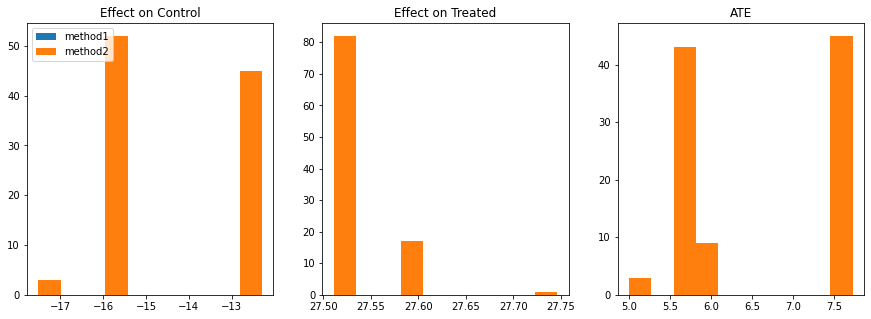

In [11]:
cv = KFold(n_splits=n_splits)
samples0 = shuffled_samples(len(X0_train),simulations)
samples1 = shuffled_samples(len(X1_train),simulations)
est02, est12 = select_and_visualise(m, samples0, samples1, cv)

### Boostrapping

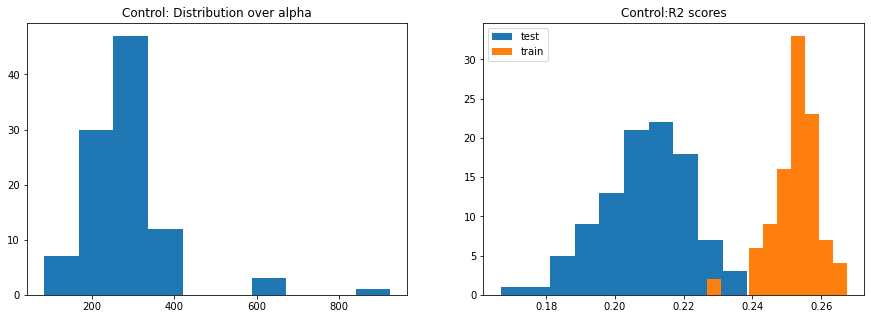

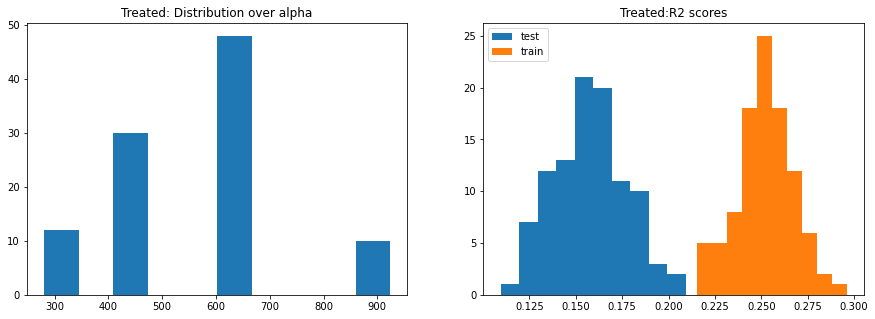

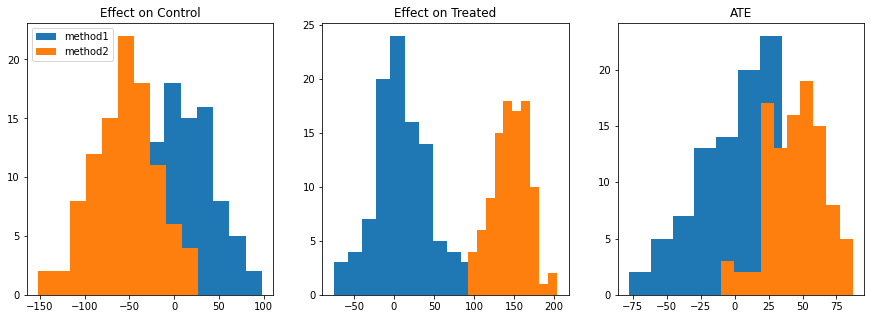

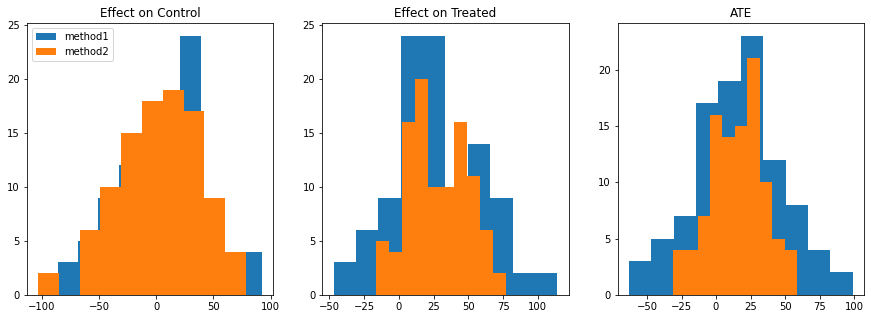

In [12]:
cv = GroupAwareKFold(n_splits=n_splits)
samples0 = bootstrap_samples(len(X0_train),simulations)
samples1 = bootstrap_samples(len(X1_train),simulations)

est03, est13 = select_and_visualise(m, samples0, samples1, cv)

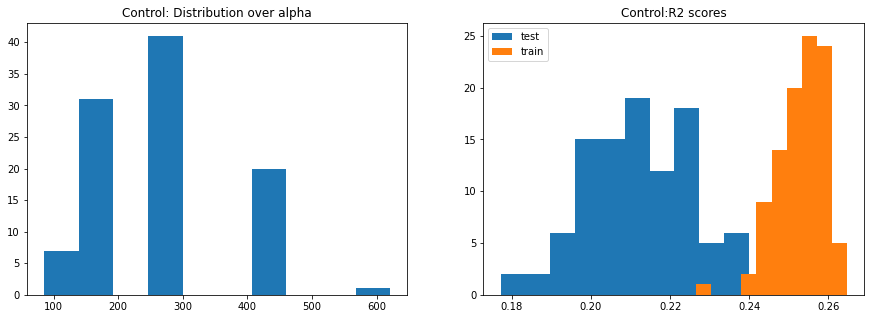

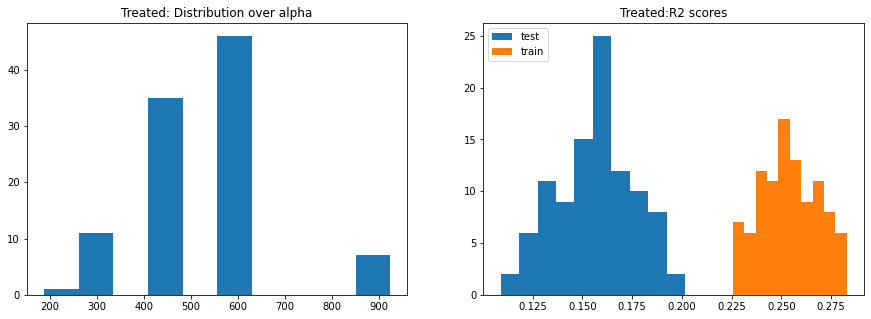

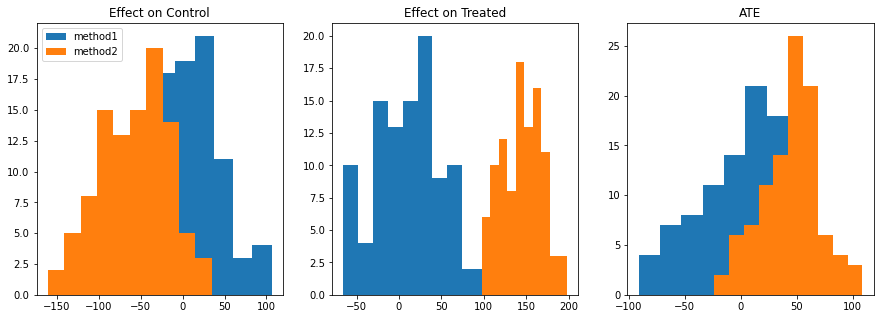

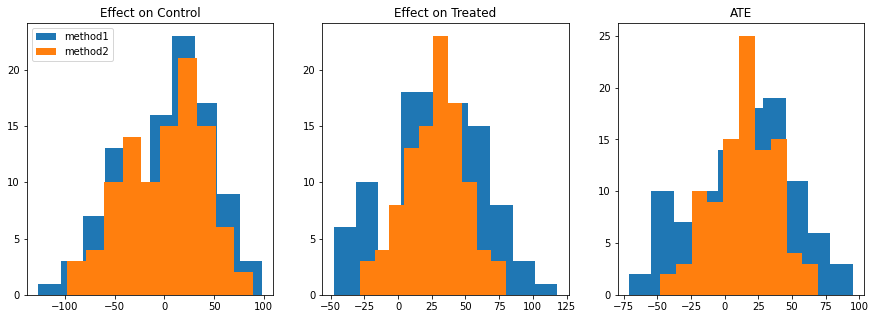

In [13]:
cv = GroupKFold(n_splits=n_splits)
samples0 = bootstrap_samples(len(X0_train),simulations)
samples1 = bootstrap_samples(len(X1_train),simulations)
est04, est14 = select_and_visualise(m, samples0, samples1, cv)

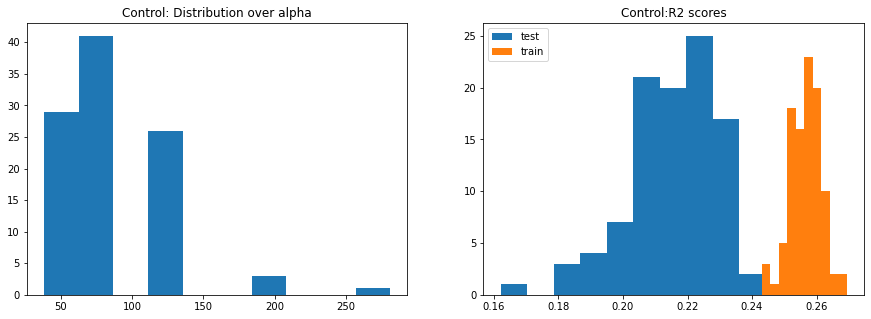

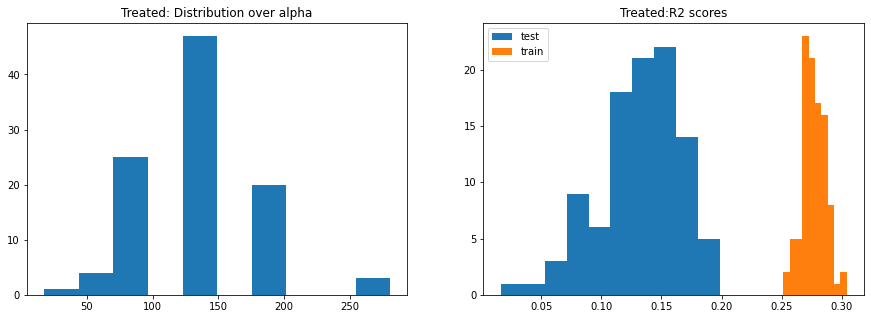

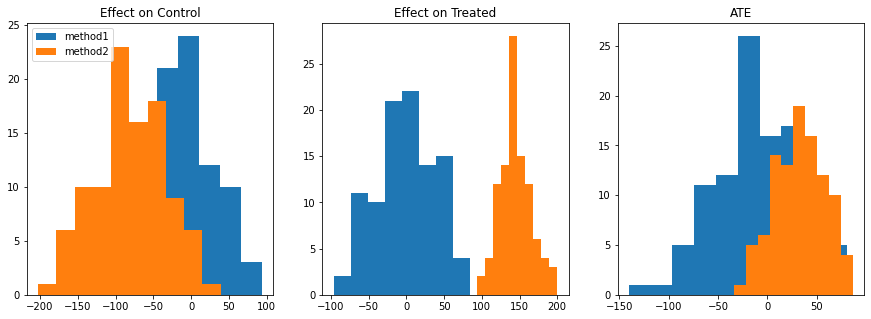

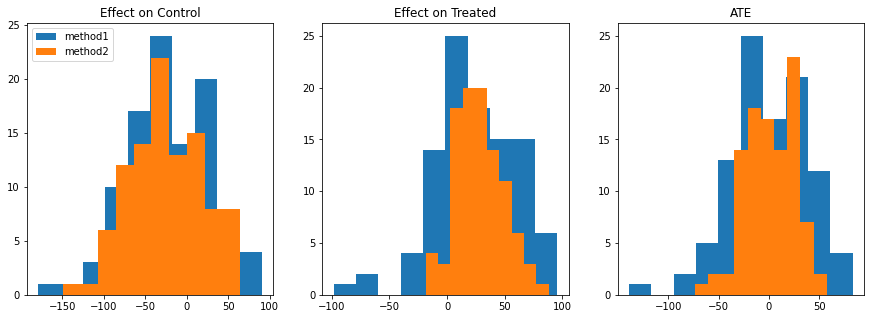

In [14]:
cv = KFold(n_splits=n_splits)
samples0 = bootstrap_samples(len(X0_train),simulations)
samples1 = bootstrap_samples(len(X1_train),simulations)

est05, est15 = select_and_visualise(m, samples0, samples1, cv)

In [23]:
summary = {
    "GroupAwareKFold over shuffled samples":(est01, est11),
    "KFold over shuffled samples":(est02, est12),
    "GroupAwareKFold over bootstrapped samples":(est03, est13),
    "GroupKFold over bootstrapped samples":(est04, est14),
    "KFold over bootstrapped samples":(est05, est15)
}
print ("ATE estimated by using estimators to predict all outcomes.")
for name, (e0, e1) in summary.items():
    eoc, eot, tau = estimate_tau(e0, e1, X0, X1)
    print(f"{name}:{np.mean(tau):.3f} ({np.std(tau):.3f})")
    
print("\n")
print ("ATE estimated by using estimators to counterfauctuals.")
for name, (e0, e1) in summary.items():
    eoc, eot, tau = estimate_tau2(e0, e1, X0, X1,y0,y1)
    print(f"{name}:{np.mean(tau):.3f} ({np.std(tau):.3f})")

ATE estimated by using estimators to predict all outcomes.
GroupAwareKFold over shuffled samples:3.493 (1.010)
KFold over shuffled samples:3.484 (0.971)
GroupAwareKFold over bootstrapped samples:14.003 (32.204)
GroupKFold over bootstrapped samples:12.319 (37.836)
KFold over bootstrapped samples:-1.839 (39.055)


ATE estimated by using estimators to counterfauctuals.
GroupAwareKFold over shuffled samples:14.159 (0.845)
KFold over shuffled samples:14.147 (0.818)
GroupAwareKFold over bootstrapped samples:22.662 (19.383)
GroupKFold over bootstrapped samples:21.670 (23.900)
KFold over bootstrapped samples:9.895 (24.405)
